In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import detrend, resample

### Define Model

In [7]:
def delayed_second_order_system(t, K, tau, zeta, T):
    response = np.zeros_like(t)
    delayed_t = t - T
    valid_idx = delayed_t >= 0
    exp_term = np.exp(-zeta * delayed_t[valid_idx] / tau)
    sin_term = np.sin(np.sqrt(1 - zeta**2) * delayed_t[valid_idx] / tau)
    cos_term = np.cos(np.sqrt(1 - zeta**2) * delayed_t[valid_idx] / tau)
    response[valid_idx] = K * (1 - exp_term * (cos_term + zeta * sin_term / np.sqrt(1 - zeta**2)))
    return response

### Load the Data

In [8]:
# Load and preprocess the data
experiments = [
    'Data/samsun low light window 7cm/7cm/trial01_DR_sos_eigenmania_fish01_IL_WY_LS_CL_Fri_Sep_16_10_04_22_2022_TRACK.xlsx',
    'Data/samsun low light window 7cm/7cm/trial02_DR_sos_eigenmania_fish01_IL_WY_LS_CL_Fri_Sep_16_10_08_20_2022_TRACK.xlsx',
    'Data/samsun low light window 7cm/7cm/trial03_DR_sos_eigenmania_fish01_IL_WY_LS_CL_Fri_Sep_16_10_10_11_2022_TRACK.xlsx',
    'Data/samsun low light window 7cm/7cm/trial04_DR_sos_eigenmania_fish01_IL_WY_LS_CL_Fri_Sep_16_10_11_50_2022_TRACK.xlsx',
    'Data/samsun low light window 7cm/7cm/trial05_DR_sos_eigenmania_fish01_IL_WY_LS_CL_Fri_Sep_16_10_13_41_2022_TRACK.xlsx',
]

trials = []
cage = None

# Load the data and resample each trial to match the length of the first trial
for experiment in experiments:
    table = pd.read_excel(experiment)
    fish_data = detrend(table['Fish'])
    if cage is None:
        cage = detrend(table['Cage'])
        t = np.arange(len(cage))
    else:
        # Resample the fish data to match the length of the cage data
        fish_data = resample(fish_data, len(cage))
    trials.append(fish_data)


### Fit the Model to the Data

In [9]:
# Stack trials data for fitting
output = np.hstack(trials)

# Repeat the input 'cage' for each trial
input_repeated = np.tile(cage, len(trials))

# Initial guess for K, tau, zeta, and T
initial_guess = [1.0, 1.0, 0.5, 1.0]

# Fit the model
params, covariance = curve_fit(delayed_second_order_system, t, output[:len(t)], p0=initial_guess)
K_est, tau_est, zeta_est, T_est = params

print(f"Estimated parameters: K = {K_est}, tau = {tau_est}, zeta = {zeta_est}, T = {T_est}")

Estimated parameters: K = -0.6453886535491653, tau = 0.0866004219446231, zeta = 0.7426338658454481, T = 63.89088055723442


/var/folders/_5/_d1ly4l548v7j_tps91_9q5h0000gn/T/ipykernel_8534/2302844471.py:5: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-zeta * delayed_t[valid_idx] / tau)
/var/folders/_5/_d1ly4l548v7j_tps91_9q5h0000gn/T/ipykernel_8534/2302844471.py:6: RuntimeWarning: invalid value encountered in sqrt
  sin_term = np.sin(np.sqrt(1 - zeta**2) * delayed_t[valid_idx] / tau)
/var/folders/_5/_d1ly4l548v7j_tps91_9q5h0000gn/T/ipykernel_8534/2302844471.py:7: RuntimeWarning: invalid value encountered in sqrt
  cos_term = np.cos(np.sqrt(1 - zeta**2) * delayed_t[valid_idx] / tau)
/var/folders/_5/_d1ly4l548v7j_tps91_9q5h0000gn/T/ipykernel_8534/2302844471.py:8: RuntimeWarning: invalid value encountered in sqrt
  response[valid_idx] = K * (1 - exp_term * (cos_term + zeta * sin_term / np.sqrt(1 - zeta**2)))


### Visualize the Results

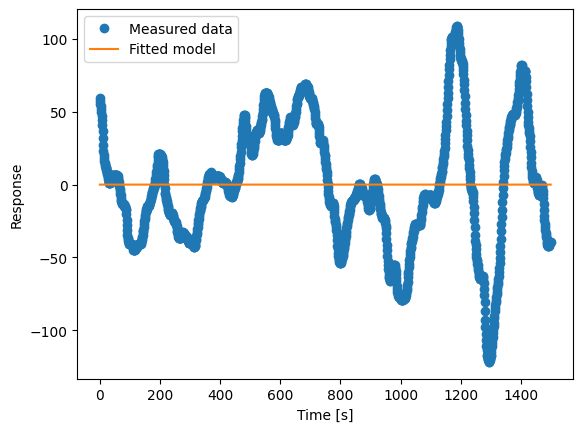

In [11]:
# Plot the results for one of the trials
plt.figure()
plt.plot(t, trials[0], 'o', label='Measured data')
plt.plot(t, delayed_second_order_system(t, K_est, tau_est, zeta_est, T_est), '-', label='Fitted model')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.show()